## Introduction

In this project I shall try to predict the stock market with various methods. 

The inspiration for this project is from a DataQuest guided project, however, in this case I barely followed the instructions (I chose the "new" metrics from a list of suggestions provided by them, but that's about it).

The data is originated from S&P500 index, and contains historical data (Open, High, Low, Close, Volume, Adj Close prices). I shall use the historical data from 1950 to 2013 to try and predict the prices for the rest until 2015. 

The notebook is built up as: 

    - Loading & cleaning the data (though I suspect it is mostly clean)
    - Estabilishing & calculating new metrics (I intend to keep them low in numbers - let's say 3/5 - and mostly with averages - no momentums as of yet - as I don't want the result to be very complicated)
    - After this I shall try a few models to "predict the stock market" for the remainder of the data. Right now I plan on implementing the following models (more or less ordered by 'increasingly complicated'):
        
        - Simple linear regression model (+  probably GLM)  
        - ARIMA, SARIMA model
        - LSTM (or other 'deep' model), XGBoost <-- as this latter seems to be very popular for predictions as well. 





**This notebook does not contain stock trading advice in any way, shape or form!
Its purpose is purely to practice time-series prediction and analysis!**

-- I have heard that it is a good idea to write this in case someone finds the notebook and thinks they can win big money based on it--

## Data exploration

And now, I shall load and inspect the data. If there are any inconsistencies (ie. NaN values, outliers), I shall handle them.
In this step I also split the data - at least define a train set. 

In [74]:
import pandas as pd
from datetime import datetime
import numpy as np

df=pd.read_csv("sphist.csv")
df.Date=pd.to_datetime(df.Date)
df.rename({"Adj Close": "adj_close"}, axis=1, inplace=True)#
df=df.sort_values("Date")

train_df=df[df["Date"]<datetime(year=2015, month=4, day=1)]
test_df=df[df["Date"]>datetime(year=2015, month=4, day=1)]
train_df

,Date,Open,High,Low,Close,Volume,adj_close
16589,1950-01-03,16.660000,16.660000,16.660000,16.660000,1.260000e+06,16.660000
16588,1950-01-04,16.850000,16.850000,16.850000,16.850000,1.890000e+06,16.850000
16587,1950-01-05,16.930000,16.930000,16.930000,16.930000,2.550000e+06,16.930000
16586,1950-01-06,16.980000,16.980000,16.980000,16.980000,2.010000e+06,16.980000
16585,1950-01-09,17.080000,17.080000,17.080000,17.080000,2.520000e+06,17.080000
...,...,...,...,...,...,...,...
178,2015-03-25,2093.100098,2097.429932,2061.050049,2061.050049,3.521140e+09,2061.050049
177,2015-03-26,2059.939941,2067.149902,2045.500000,2056.149902,3.510670e+09,2056.149902
176,2015-03-27,2055.780029,2062.830078,2052.959961,2061.020020,3.008550e+09,2061.020020
175,2015-03-30,2064.110107,2088.969971,2064.110107,2086.239990,2.917690e+09,2086.239990


In [75]:
train_df.describe()

,Open,High,Low,Close,Volume,adj_close
count,16416.000000,16416.000000,16416.000000,16416.000000,1.641600e+04,16416.000000
mean,465.833007,468.805688,462.719071,465.957217,7.639047e+08,465.957217
std,533.302832,536.533511,529.862851,533.435266,1.432842e+09,533.435266
min,16.660000,16.660000,16.660000,16.660000,6.800000e+05,16.660000
25%,83.459999,84.169998,82.804999,83.470001,7.307500e+06,83.470001
50%,135.180000,136.555001,133.915001,135.264999,6.524500e+07,135.264999
75%,919.739990,928.965011,911.214982,919.647491,7.031500e+08,919.647491
max,2115.760010,2119.590088,2109.889893,2117.389893,1.145623e+10,2117.389893


Cool. It seems I have no missing values or values that would be very suspicious. 
I shall just plot... let's say the close price just to see how exactly this looks like.

Also, while we're at it... let's make the "date" the index.

In [76]:
import matplotlib.pyplot as plt

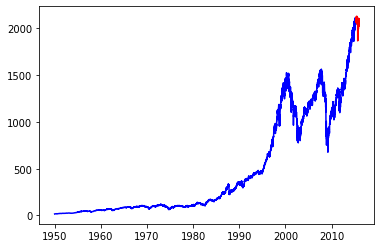

In [77]:
train_df.index=train_df.Date
test_df.index=test_df.Date
plt.plot(train_df.Close, "b-")
plt.plot(test_df.Close,"r-")

Cool! There seems to be a downspike in red - I'm curious how the models will handle that!

# Feature engineering - new features

### Endless possibilities

As stated above, I don't intend to use momentums, just averages and standard deviations, and only 3 of those. Of course, there are a bunch of possible metrics even with these boundaries, for example: 

    -The average price from the past 5 (trading) days (A trading week).
    -The average price for the past 30 days (A month).
    -The average price for the past 365 days (A year).
    -The ratio between the average price for the past 5 days, and the average price for the past 365 days.
    -The standard deviation of the price over the past 5 (trading) days.
    -The standard deviation of the price over the past 365 days.
    -The ratio between the standard deviation for the past 5 days, and the standard deviation for the past 365 days.
    


### My picks

I shall only pick three, and my gut tells me (remember, this is not stock trading advice, just my journey towards... well, learning more :) ) that I should pick: 

    -Average price of past 5 days - As this should indicate the short-term trends
    - Average price of the past 365 days - as this should indicate both the long-term trends AND the "seasonality" (though this latter will be less important to state explicitly once SARIMA comes to play) /Rather: I shall use the past 261 *trading* days as... in most years (5 out of 7 times) this corresponds to the year, and this is much easier to calculate. I also don't think this would make the model any less accurate
    (- I would love to use their ratio as well, but well... rules are rules, and that would not be my 3rd and last pick)
    - My last pick would be the standard deviation of the last 365 days as this could probably tell me about how today (and the last week) 'behaves' compared to the 'normal'.
    
Now that I'm done with defining the three features I wish to use, time to compute them for each day. 

I also think it might be a good idea to 

I'm going to use the adjusted price as... well, that price is the more accurate - or so I heard.


In [78]:
last_5=[]#Contains the last 5 day's data
last_261=[]#contains the last year

for idx, row in df.iterrows():# Yes, I use the DF again as... well, no changes have been made and this way I don't have to 'peek' back to the train set for the first 5 values of the test set...
    if len(last_5)<5:
        last_5.append(row.adj_close)
        last_261.append(row.adj_close)
    elif len(last_261)<261:
        df.loc[idx, "avg_5"]=np.mean(last_5)
        last_5.pop(0)#Swap out the oldest data
        last_5.append(row.adj_close)
        last_261.append(row.adj_close)
    else:
        df.loc[idx, "avg_5"]=np.mean(last_5)
        df.loc[idx, "avg_year"]=np.mean(last_261)
        df.loc[idx, "std_year"]=np.std(last_261)
        last_5.pop(0)#Swap out the oldest data
        last_261.pop(0)#Swap out the oldest data
        last_5.append(row.adj_close)
        last_261.append(row.adj_close) 


In [79]:
df.reset_index(drop=True, inplace=True)#This is just so I can check easily for the following output
df.loc[255:265,]

,Date,Open,High,Low,Close,Volume,adj_close,avg_5,avg_year,std_year
255,1951-01-10,20.850000,20.850000,20.850000,20.850000,3270000.0,20.850000,20.910001,NaN,NaN
256,1951-01-11,21.190001,21.190001,21.190001,21.190001,3490000.0,21.190001,20.942001,NaN,NaN
257,1951-01-12,21.110001,21.110001,21.110001,21.110001,2950000.0,21.110001,21.006001,NaN,NaN
258,1951-01-15,21.299999,21.299999,21.299999,21.299999,2830000.0,21.299999,21.054001,NaN,NaN
259,1951-01-16,21.459999,21.459999,21.459999,21.459999,3740000.0,21.459999,21.114000,NaN,NaN
260,1951-01-17,21.549999,21.549999,21.549999,21.549999,3880000.0,21.549999,21.182000,NaN,NaN
261,1951-01-18,21.400000,21.400000,21.400000,21.400000,3490000.0,21.400000,21.322000,18.519923,1.175921
262,1951-01-19,21.360001,21.360001,21.360001,21.360001,3170000.0,21.360001,21.364000,18.538084,1.183633
263,1951-01-22,21.180000,21.180000,21.180000,21.180000,2570000.0,21.180000,21.414000,18.555364,1.191755
264,1951-01-23,21.260000,21.260000,21.260000,21.260000,2080000.0,21.260000,21.390000,18.571648,1.198452


Neat! I have my three extra metrics set up properly. Now I will make the train-test split (again), make the index the date (again), and drop the times when I don't have one of the metrics set up (so basically... the first year)

In [82]:
train_df=df[df["Date"]<datetime(year=2013, month=1, day=1)]
test_df=df[df["Date"]>=datetime(year=2013, month=1, day=1)]
train_df.index=train_df.Date
test_df.index=test_df.Date
train_df=train_df.dropna()


In [83]:
train_df

,Date,Open,High,Low,Close,Volume,adj_close,avg_5,avg_year,std_year
Date,,,,,,,,,,
1951-01-18,1951-01-18,21.400000,21.400000,21.400000,21.400000,3.490000e+06,21.400000,21.322000,18.519923,1.175921
1951-01-19,1951-01-19,21.360001,21.360001,21.360001,21.360001,3.170000e+06,21.360001,21.364000,18.538084,1.183633
1951-01-22,1951-01-22,21.180000,21.180000,21.180000,21.180000,2.570000e+06,21.180000,21.414000,18.555364,1.191755
1951-01-23,1951-01-23,21.260000,21.260000,21.260000,21.260000,2.080000e+06,21.260000,21.390000,18.571648,1.198452
1951-01-24,1951-01-24,21.160000,21.160000,21.160000,21.160000,1.990000e+06,21.160000,21.350000,18.588046,1.205820
...,...,...,...,...,...,...,...,...,...,...
2012-12-24,2012-12-24,1430.150024,1430.150024,1424.660034,1426.660034,1.248960e+09,1426.660034,1437.360010,1370.075440,56.261886
2012-12-26,2012-12-26,1426.660034,1429.420044,1416.430054,1419.829956,2.285030e+09,1419.829956,1436.620019,1370.812260,55.736383
2012-12-27,2012-12-27,1419.829956,1422.800049,1401.800049,1418.099976,2.830180e+09,1418.099976,1431.228003,1371.443065,55.354602


## Linear regression - Error metric

Picking an error metric is not always an obvious choice. I shall pick the MSE as this is the most commonly used metric - this doesn't necessarily mean that it's the best! 

For now I will use only the last three columns to predict the close price - as any other columns would "leak" info from the current day. 

In this model I don't expect high accuracy.

Right now i don't re-scale the data as...well, this is a linear regression, it doesn't need to have such fancy transformations.

In [114]:
from sklearn.linear_model import LinearRegression # a simple regression
from sklearn.metrics import mean_squared_error # THe metric of my choice
import matplotlib.dates as mdates

In [247]:
def train_and_predict(train, test, features, target, visu=1):
    #Visu=0: no plots
    #Visu=1: only the prices next to the actual prices
    #Visu=2: I shall also plot the error of the prediction vs. time - as this might be a better indicator
    #Init
    lr=LinearRegression()
    #train
    lr.fit(train[features], train[target])
    #predict
    predictions=lr.predict(test[features])
    #calculate the error
    mse=mean_squared_error(test[target], predictions)
    change=test.Close.values[:-1]-test.Close.values[1:]
    if visu>0:
        plt.figure()
        plt.plot(test.Close, "g-", alpha=.5, label="Actual close prices")
        plt.plot(test.Date, predictions, "r-", label="predicted close prices")
        plt.legend()
        plt.title("Prediction of a linear model")
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
        plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))
        plt.gcf().autofmt_xdate()
    if visu==2:
        plt.figure()
        plt.plot(test.Date, predictions-test.Close.values, "r-", label="Error of the prediction")
        plt.plot(test.Date.values[1:], change, "k-", alpha=.5, label="changes from the previous day")
        plt.legend()
        plt.title("Error of the prediction")
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
        plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))
        plt.gcf().autofmt_xdate()
    if visu==3:
        fig, ax=plt.subplots()
        ax.plot(test.Date.values[1:], abs(predictions[1:]-test.Close.values[1:])-abs(change), "k-", label="Difference in errors")
        ax.axhline(0,c="r", alpha=.5 )
        ax.axhline(np.mean( abs(predictions[1:]-test.Close.values[1:])-abs(change)), c="b", alpha=.5)
        plt.legend()
        plt.title("Error of the prediction")
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
        plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))
        plt.gcf().autofmt_xdate()
        print(np.mean( abs(predictions[1:]-test.Close.values[1:])-abs(change)))
    return [mse, predictions]# I return the predictions so I can compare later

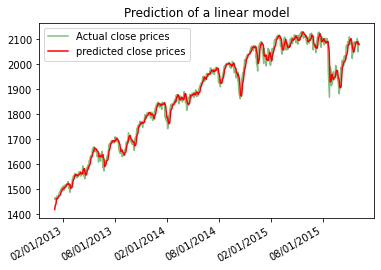

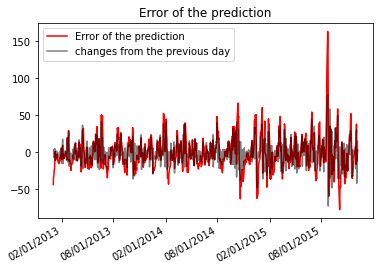

In [147]:
features=["avg_5", "avg_year", "std_year"]#These are the features I have for now
mse_1, first_pred=train_and_predict(train_df, test_df, features, "Close", visu=2)

5.202561018508567


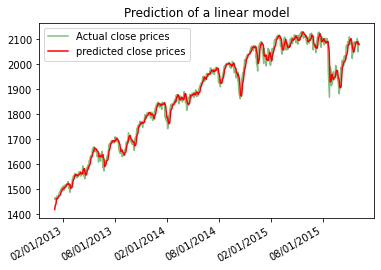

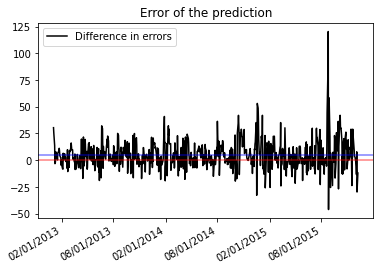

In [121]:
mse, first_pred=train_and_predict(train_df, test_df, features, "Close", visu=3)

There is something I like to try - and have coded above just to show now:

If I built a predictor and all it did was mindlessly throwing the previous day's closing price as a "prediction" for today's closing price, it would do _slightly_ better on average than my current predictor. 

This is still not terrible news (as my current predictor had no idea about the previous closing price whatsoever - if it had, then the prediction would clearly be worse than doing the mindless "giving back") but it shows that my model is very far from models that could achieve success on the markets.


## Reflection - First prediction:

This is a pretty prediction, however I think I can do better. 

I will introduce new variables such as "yesterday's high/low" (I'm not sure about the "close" - I don't want that to avoid bias, but one could try it...). 
I will also use the "volume" column of the previous day as it might add to the prediction.

DQ have also proposed ideas that might be helpful for further training:

    The average volume over the past five days.
    The average volume over the past year.
    The ratio between the average volume for the past five days, and the average volume for the past year.
    The standard deviation of the average volume over the past five days.
    The standard deviation of the average volume over the past year.
    The ratio between the standard deviation of the average volume for the past five days, and the standard deviation of the average volume for the past year.
    The year component of the date.
    The ratio between the lowest price in the past year and the current price.
    The ratio between the highest price in the past year and the current price.
    The month component of the date.
    The day of week.
    The day component of the date.
    The number of holidays in the prior month.

Now for some I think I can tell outright that they are probably useless. 

I should pick two regardless...

I think I will pick: 

    - average volume of the past 5 days - I already have the volume of the previous day, but I think the short-term prediction might be "drown out" if I take the year.
    - I also take the average volume of the past year (261 days) - this might also have some indication for the longer term trends
    - One more: the average volume of the past year's first 5 days - if that makes sense. I expect this to indicate seasonal trends, but I might be waay off. 
    
Let's rebuild the df keeping these in mind!



In [157]:
last_5_v=[]#Contains the last 5 day's data
last_261_v=[]#contains the last year
prev_high=np.nan
prev_low=np.nan
prev_vol=np.nan
for idx, row in df.iterrows():# Yes, I use the DF again as... well, no changes have been made and this way I don't have to 'peek' back to the train set for the first 5 values of the test set...
    #this happens regardless
    df.loc[idx, "yesterday_high"]=prev_high
    df.loc[idx, "yesterday_low"]=prev_low
    df.loc[idx, "yesterday_volume"]=prev_vol
    prev_high=row.High
    prev_low=row.Low
    prev_vol=row.Volume
    if len(last_5_v)<5:
        last_5_v.append(row.Volume)
        last_261_v.append(row.Volume)
    elif len(last_261_v)<261:
        df.loc[idx, "avg_5"]=np.mean(last_5)
        last_5_v.pop(0)#Swap out the oldest data
        last_5_v.append(row.Volume)
        last_261_v.append(row.Volume)
    else:
        df.loc[idx, "last_5_volume"]=np.mean(last_5_v)
        df.loc[idx, "last_year_volume"]=np.mean(last_261_v)
        df.loc[idx, "volume_a_yr_ago"]=np.mean(last_261_v[:5])
        last_5_v.pop(0)#Swap out the oldest data
        last_261_v.pop(0)#Swap out the oldest data
        last_5_v.append(row.Volume)
        last_261_v.append(row.Volume) 


In [158]:
df

,Date,Open,High,Low,Close,Volume,adj_close,avg_5,avg_year,std_year,yesterday_high,yesterday_low,yesterday_volume,last_5_volume,last_year_volume,volume_a_yr_ago
0,1950-01-03,16.660000,16.660000,16.660000,16.660000,1.260000e+06,16.660000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1950-01-04,16.850000,16.850000,16.850000,16.850000,1.890000e+06,16.850000,NaN,NaN,NaN,16.660000,16.660000,1.260000e+06,NaN,NaN,NaN
2,1950-01-05,16.930000,16.930000,16.930000,16.930000,2.550000e+06,16.930000,NaN,NaN,NaN,16.850000,16.850000,1.890000e+06,NaN,NaN,NaN
3,1950-01-06,16.980000,16.980000,16.980000,16.980000,2.010000e+06,16.980000,NaN,NaN,NaN,16.930000,16.930000,2.550000e+06,NaN,NaN,NaN
4,1950-01-09,17.080000,17.080000,17.080000,17.080000,2.520000e+06,17.080000,NaN,NaN,NaN,16.980000,16.980000,2.010000e+06,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16585,2015-12-01,2082.929932,2103.370117,2082.929932,2102.629883,3.712120e+09,2102.629883,2087.024023,2061.027205,54.222975,2093.810059,2080.409912,4.245030e+09,3.207544e+09,3.618424e+09,3.400928e+09
16586,2015-12-02,2101.709961,2104.270020,2077.110107,2079.510010,3.950640e+09,2079.510010,2090.231982,2061.262109,54.269873,2103.370117,2082.929932,3.712120e+09,3.232372e+09,3.620567e+09,3.395962e+09
16587,2015-12-03,2080.709961,2085.000000,2042.349976,2049.620117,4.306490e+09,2049.620117,2088.306006,2061.368277,54.278363,2104.270020,2077.110107,3.950640e+09,3.245514e+09,3.622614e+09,3.391312e+09
16588,2015-12-04,2051.239990,2093.840088,2051.239990,2091.689941,4.214910e+09,2091.689941,2080.456006,2061.371726,54.277587,2085.000000,2042.349976,4.306490e+09,3.536224e+09,3.626123e+09,3.262194e+09


This seems to work just fine!

Now let's redistribute the train & test set and use the above defined function to predict again!

In [197]:
train_df=df[df["Date"]<datetime(year=2013, month=1, day=1)]
test_df=df[df["Date"]>=datetime(year=2013, month=1, day=1)]
train_df.index=train_df.Date
test_df.index=test_df.Date
train_df=train_df.dropna()
features=df.columns[-9:]
features

Index(['avg_5', 'avg_year', 'std_year', 'yesterday_high', 'yesterday_low',
       'yesterday_volume', 'last_5_volume', 'last_year_volume',
       'volume_a_yr_ago'],
      dtype='object')

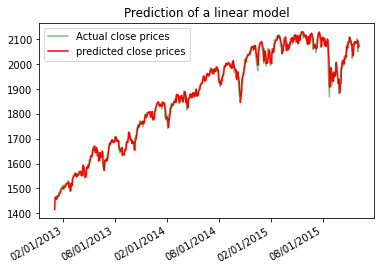

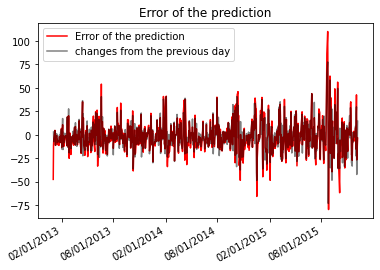

In [160]:
mse_2, second_pred=train_and_predict(train_df, test_df, features, "Close", visu=2)

1.2004847766795113


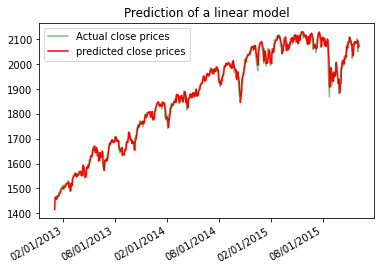

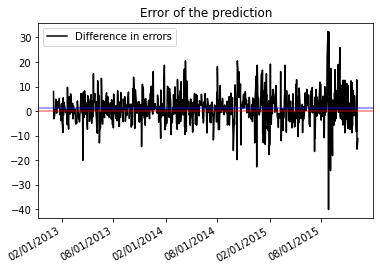

In [161]:
mse, second_pred=train_and_predict(train_df, test_df, features, "Close", visu=3)

In [162]:
print(mse_1)
print(mse_2)

493.8778991098761
286.58034192785


## Reflections - second prediction

We have managed to cut the MSE in... almost half, but I believe we can still do better through better feature selection!

I could perform the feature selection through looking at the correlations. However, I think for now I want to go another route...
## Recursive feature elimination!
    
I shall run a prediction for each feature without the feature in question and then see whether the MSE improved or not. 

If it did, then the feature is probably more noise than anything, and I will look into cutting it.


In [188]:
def selective_elim(features,  train_df, test_df, orig_mse):
    print(str(orig_mse)+ " is the current MSE.")
    for idx in range(len(features)):# I use the range-len since I want the indexes
        pseu_features=features.copy()
        now_tested=pseu_features.pop(idx)
        mse, _ = train_and_predict(train_df, test_df, pseu_features, "Close", visu=0)
        print ("\n Without "+now_tested + " the MSE is " +str(round(mse, 2))+", a "+ str(round(abs(mse-orig_mse), 2))+[" increase", " decrease"][int(orig_mse>mse)]+" compared to the original.")

In [189]:
selective_elim(list(features.values), train_df, test_df, mse_2)

286.58034192785 is the current MSE.

 Without avg_5 the MSE is 288.4, a 1.82 increase compared to the original.

 Without avg_year the MSE is 286.49, a 0.09 decrease compared to the original.

 Without std_year the MSE is 286.52, a 0.06 decrease compared to the original.

 Without yesterday_high the MSE is 303.96, a 17.37 increase compared to the original.

 Without yesterday_low the MSE is 315.56, a 28.98 increase compared to the original.

 Without yesterday_volume the MSE is 286.3, a 0.28 decrease compared to the original.

 Without last_5_volume the MSE is 284.6, a 1.98 decrease compared to the original.

 Without last_year_volume the MSE is 285.01, a 1.57 decrease compared to the original.

 Without volume_a_yr_ago the MSE is 286.28, a 0.3 decrease compared to the original.


## Reflections - Second prediction:

The volume does not seem to help whatsoever, so I think I can remove them without consequences. 

As for the others - I would not remove any more values - maybe even add 'yesterday's close'.

## Linear fit - Third prediction:

Before leaving the linear fit behind, I will try to improve the MSE. and that would be changing the way the train & test fit works, to use **all** the data accumulated to predict only the next day. 

I shall also create a few more indicators (from the above lists) to see if there is an increase - I know that this is a bad practice (if I have a significant increase I would not know which change did it), but I don't think it is necessary to do this in two steps with the linear model for now, as I intend to move on for other models.

This probably will make the code run for a longer time, but for now it does run instantly so I don't mind a bit of delay.

In [238]:
last_5_c=[]#Contains the last 5 day's data
last_20=[]#Contains the last month - or... well, 4 weeks.
#last_261=[]#contains the last year - I already have STD and mean for this
for idx, row in df.iterrows():# Yes, I use the DF again as... well, no changes have been made and this way I don't have to 'peek' back to the train set for the first 5 values of the test set...
    if len(last_5_c)<5:
        last_5_c.append(row.Close)
 #       last_261.append(row.Close)
        last_20.append(row.Close)
    elif len(last_20)<20:
        df.loc[idx, "std_5_close"]=np.std(last_5_c)
        last_5_c.pop(0)#Swap out the oldest data
        last_5_c.append(row.Close)
        last_20.append(row.Close)
  #      last_261.append(row.Close)        
#     elif len(last_261)<261:
#         df.loc[idx, "std_5_close"]=np.std(last_5)
#         df.loc[idx, "avg_month_close"]=np.mean(last_20)
#         df.loc[idx, "std_month_close"]=np.std(last_20)
#         last_5.pop(0)#Swap out the oldest data
#         last_20.pop(0)
#         last_5_v.append(row.Close)
#         last_20.append(row.Close)
#         last_261_v.append(row.Close) 
    else:
        df.loc[idx, "std_5_close"]=np.std(last_5_c)
        df.loc[idx, "std_20_close"]=np.std(last_20)
        df.loc[idx, "last_20_close"]=np.mean(last_20)
        last_5_c.pop(0)#Swap out the oldest data
     #   last_261.pop(0)#Swap out the oldest data
        last_20.pop(0)
        last_20.append(row.Close)
        last_5_c.append(row.Close)
    #    last_261.append(row.Close) 
df.loc[15:25,]

,Date,Open,High,Low,Close,Volume,adj_close,avg_5,avg_year,std_year,yesterday_high,yesterday_low,yesterday_volume,last_5_volume,last_year_volume,volume_a_yr_ago,std_5_close,std_20_close,last_20_close
15,1950-01-24,16.860001,16.860001,16.860001,16.860001,1250000.0,16.860001,2080.104004,NaN,NaN,16.920000,16.920000,1340000.0,NaN,NaN,NaN,0.026077,NaN,NaN
16,1950-01-25,16.740000,16.740000,16.740000,16.740000,1700000.0,16.740000,2080.104004,NaN,NaN,16.860001,16.860001,1250000.0,NaN,NaN,NaN,0.026077,NaN,NaN
17,1950-01-26,16.730000,16.730000,16.730000,16.730000,1150000.0,16.730000,2080.104004,NaN,NaN,16.740000,16.740000,1700000.0,NaN,NaN,NaN,0.062738,NaN,NaN
18,1950-01-27,16.820000,16.820000,16.820000,16.820000,1250000.0,16.820000,2080.104004,NaN,NaN,16.730000,16.730000,1150000.0,NaN,NaN,NaN,0.080000,NaN,NaN
19,1950-01-30,17.020000,17.020000,17.020000,17.020000,1640000.0,17.020000,2080.104004,NaN,NaN,16.820000,16.820000,1250000.0,NaN,NaN,NaN,0.072000,NaN,NaN
20,1950-01-31,17.049999,17.049999,17.049999,17.049999,1690000.0,17.049999,2080.104004,NaN,NaN,17.020000,17.020000,1640000.0,NaN,NaN,NaN,0.104995,0.126139,16.8670
21,1950-02-01,17.049999,17.049999,17.049999,17.049999,1810000.0,17.049999,2080.104004,NaN,NaN,17.049999,17.049999,1690000.0,NaN,NaN,NaN,0.137025,0.122730,16.8865
22,1950-02-02,17.230000,17.230000,17.230000,17.230000,2040000.0,17.230000,2080.104004,NaN,NaN,17.049999,17.049999,1810000.0,NaN,NaN,NaN,0.133356,0.127408,16.8965
23,1950-02-03,17.290001,17.290001,17.290001,17.290001,2210000.0,17.290001,2080.104004,NaN,NaN,17.230000,17.230000,2040000.0,NaN,NaN,NaN,0.130323,0.146672,16.9115
24,1950-02-06,17.320000,17.320000,17.320000,17.320000,1490000.0,17.320000,2080.104004,NaN,NaN,17.290001,17.290001,2210000.0,NaN,NaN,NaN,0.109982,0.167932,16.9270


In [251]:
def train_and_predict(whole_df, features, target, day):
    #redefined, so now I make the train-test split inside the function.
    train=whole_df[whole_df["Date"]<day]
    test=whole_df[whole_df["Date"]==day]
    #Init
    if len(test)==0:
        return [np.nan, np.nan]
    lr=LinearRegression()
    #train
    lr.fit(train[features], train[target])
    #predict
    predictions=lr.predict(test[features])
    #calculate the error
    mse=mean_squared_error(test[target], predictions)
    return [mse, predictions]# I return the predictions so I can compare later


In [252]:
features=list(df.columns[7:])
features

['avg_5',
 'avg_year',
 'std_year',
 'yesterday_high',
 'yesterday_low',
 'yesterday_volume',
 'last_5_volume',
 'last_year_volume',
 'volume_a_yr_ago',
 'std_5_close',
 'std_20_close',
 'last_20_close']

In [253]:
mse_list=[]
third_predictions=[]
pred_df=df.dropna()
for day in pd.date_range("2013-01-01", "2015-12-31"):# It doesnt matter if I go past, it will return nan
    mse, pred=train_and_predict(pred_df, features, "Close", day)
    if not np.isnan(pred):
        third_predictions.append(pred)
        mse_list.append(mse)

In [260]:
mse_3=np.mean(mse_list)
mse_3#284.16

283.1245269899339

## Reflections - Third linear:

I did not achieve a much better result than previously. 

This might be the best that I can achieve with this data through a linear fit, but I think there has to be a bit more - maybe once again with feature elimination as I have reintroduced a bunch of features... 

As for next, I think I briefly try to use a randomforest before jumping into ARIMA and/or more complex model territory...

I shall do it in... about a week? 